The current implementation of identifyFM is not as rigorously defined as I would like it to be. The current implementation works so:

* find 'tight' borders of input single call

* take measurements of tight-border-ed single call

* get peak frequency and notch-filter at this frequency

* run peak detection on remaining section. This typicaly leads to 1/2 bumps in the audio. Raise error if there are $\ge$2 peaks detected

The problem with the current implementation is essentially that sometimes even a very faint bump in the FM regions is considered a valid FM. Ideally you don't even want to consider calls like this. Moreover, the peak detection works with a time-series of any set of values. I'd like to define a peak as something that is X times more than the notch-filtered CF portion at least. If the 'detected' FM signal portion is fainter or ~= intensity as the notch filtered CF, then it's not very strong in the first place. 

The idea is to calculate a running rms of the notch-filtered call. The majority of rms values correspond to that of the part where the CF used to be. If the remaining FM parts are actually a few dB above the 'baseline' then, I'll choose to do peak-detection around then, otherwise, the call can be considered to have no FM sections. 

In [1]:
import sys 
sys.path.append('../measure_CF_calls/')


In [2]:
from measure_single_horseshoe_bat_call import *
np.random.seed(82319)

In [3]:
%matplotlib notebook

In [25]:
# check raw audo
rec, fs = sf.read('example_audio/T0000568.WAV')
start, stop = 5.633, 5.657
channel = 0
part = rec[int(start*fs):int(stop*fs),channel]
b,a = signal.butter(4,np.array([70000, 115000])/(fs*0.5), 'bandpass')
part = signal.filtfilt(b,a,part)

<IPython.core.display.Javascript object>


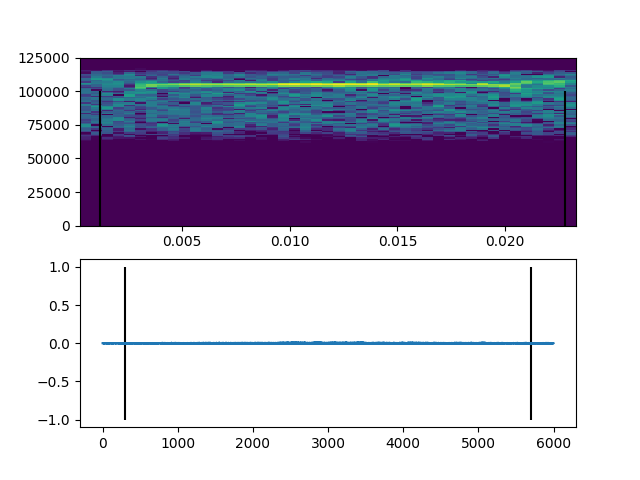

In [26]:
start, end = calc_sound_borders(part,90)
plt.figure()
plt.subplot(211)
plt.specgram(part, Fs=fs, NFFT=256, vmin=dB(np.max(part))-80);
plt.vlines(start/250000.0, 0, 100000)
plt.vlines(end/250000.0, 0, 100000)
plt.subplot(212)
plt.plot(part)
plt.vlines(start, -1,1 )
plt.vlines(end, -1,1)

In [27]:
kwargs= {}
kwargs['seg_length'] = 4096
kwargs['fs'] = 250000
kwargs['q_factor'] = 1.0

In [28]:
# narrow down the audio clip even more to extract exactly the sound
audio = part.copy()
call_window = calc_sound_borders(audio, 90) 
call = audio[call_window[0]:call_window[1]]

#identify peak frequency 
peak_frequency = get_robust_peak_frequency(call, **kwargs)

#get rid of peak frequency
call_no_CF = remove_frequency(call, peak_frequency, **kwargs)


In [29]:
call.size

5399

In [30]:
m_rms = moving_rms(call_no_CF, window_size=125)

<IPython.core.display.Javascript object>


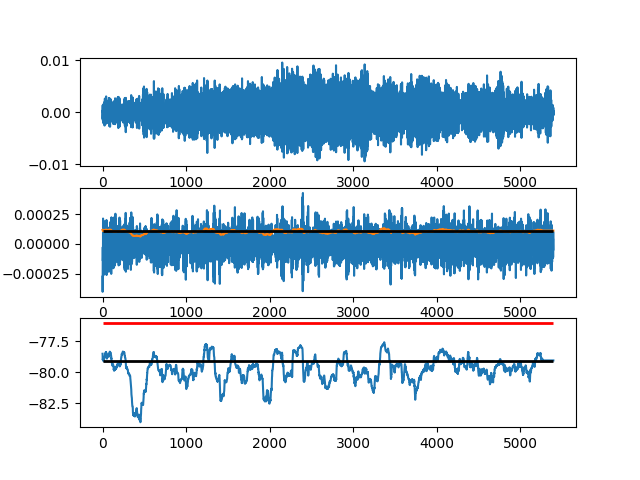

In [31]:
plt.figure()
plt.subplot(311)
plt.plot(call)
plt.subplot(312)
plt.plot(call_no_CF)
plt.hlines(np.percentile(m_rms,75),0,m_rms.shape[0],linewidth=2,zorder=3)
plt.plot(m_rms)
plt.subplot(313)
plt.plot(dB(m_rms))
db_threshold = np.percentile(dB(m_rms),75)
plt.hlines(db_threshold,0,m_rms.shape[0],linewidth=2,zorder=3)
plt.hlines(db_threshold+3,0,m_rms.shape[0],'r',linewidth=2,zorder=3)



In [32]:
def get_FM_parts(no_cf_call,**kwargs):
    '''Function which identifies and segments out FM parts. If there are no FM parts detected, 
    then an empty list is given out. 
    Kwargs
    -------
     min_fm_duration, percentile_threshold, dB_above_threshold,
     min_cf_duration, fm_max_durn
    '''
    fs = kwargs['fs']
    min_fm_duration = int(kwargs.get('min_fm_duration', 0.001)*fs)
    percentile_threshold = kwargs.get('percentile_threshold', 75)
    dB_above_threshold = kwargs.get('dB_above_threshold', 3)
    min_cf_duration = kwargs.get('min_cf_duration', 0.01)
    fm_max_durn = kwargs.get('fm_max_durn', 0.005)
    half_fm_samples = int(fm_max_durn*0.5*fs)
    
    
    # calcualte running rms and a pessimistic threshold to segment FM portions
    rms_over_call = moving_rms(no_cf_call, windowsize=min_fm_duration)
    dB_rms_over_call = dB(rms_over_call)
    threshold = np.percentile(dB_rms_over_call, percentile_threshold)
    pessimistic_threshold = threshold + dB_above_threshold
    
    # get samples aboe the pessimistic threshold
    samples_above_threshold = dB_rms_over_call >= pessimistic_threshold
    signal_above_threshold = np.zeros(dB_rms_over_call.shape)
    signal_above_threshold[samples_above_threshold] = rms_over_call[samples_above_threshold]
    
    # do peak detection on the parts that are above 
    fm_peaks = peak.indexes(signal_above_threshold.flatten(), thres=0.1, min_dist=int(min_cf_duration*fs))
    # if >2 peaks raise an error
    check_number_of_fmpeaks(fm_peaks)

    # segment and check duration of fm. If it's too short discard it. 
    fm_segments = []
    fm_times =[]
    for each_peak in fm_peaks:
        broad_fm_section, audio_startstop = take_segment_around_peak(no_cf_call, each_peak, half_fm_samples)
        fm_start,fm_stop = segment_sound_from_background(broad_fm_section,**kwargs)
        fm_duration = sound_duration(fm_start,fm_stop, **kwargs)
        if fm_duration >= min_fm_duration:
            well_segmented_fm = broad_fm_section[fm_start:fm_stop+1]
            fm_segments.append(well_segmented_fm)
            start_stop = [fm_start + audio_startstop[0], fm_start + audio_startstop[0] + well_segmented_fm.size]
            fm_times.append(start_stop)
    
    
    return fm_segments, fm_times

def check_number_of_fmpeaks(fmpeaks):
    if len(fmpeaks)>2:
        print(fmpeaks)
        raise FMIdentificationError('Too many FM peaks detected, aborting call processing..')

def sound_duration(start_sample, end_sample, **kwargs):
    '''
    Keyword Arguments
    -----------------
    fs 
    '''
    num_samples = end_sample-start_sample+1
    duration = num_samples*kwargs['fs']
    return duration
    

    
    
    
    

In [33]:
help(make_one_CFcall)

Help on function make_one_CFcall in module measure_single_horseshoe_bat_call:

make_one_CFcall(call_durn, fm_durn, cf_freq, fs, call_shape)
    TODO : make harmonics



In [34]:
fm, times =get_FM_parts(call_no_CF, fs=250000, min_fm_duration=0.001)

In [35]:
times

[]

<IPython.core.display.Javascript object>


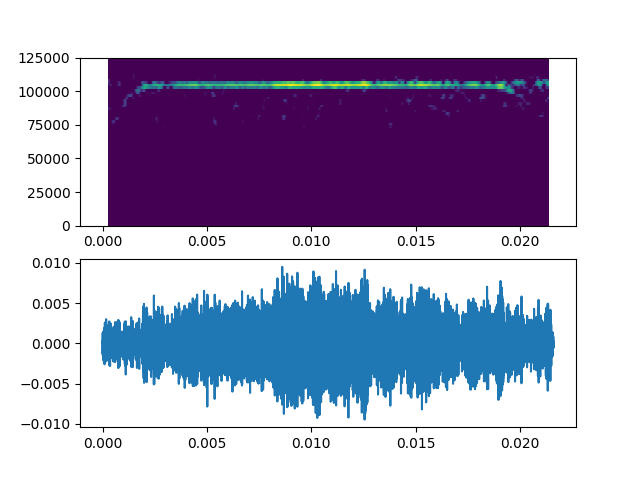

Could not display vline!!
Could not display vline!!


In [36]:
dyn = dB(np.max(abs(call))) -60
plt.figure()
a1=plt.subplot(212)
plt.plot(np.linspace(0,call.size/float(fs),call.size),call)
try:
    plt.vlines(np.concatenate(times).flatten()/float(fs), np.min(call),np.max(call))
except:
    print('Could not display vline!!')

plt.subplot(211,sharex=a1)
plt.specgram(call, Fs=250000,NFFT=128,noverlap=127, vmin=dyn)
try:
    plt.vlines(np.concatenate(times).flatten()/float(fs), 0,110000)
except:
    print('Could not display vline!!')



### How robust is the FM identification to weird calls that have NO  fm parts at all?

In [37]:
whole_call_durn = 20*10**-3
peak_f = 100000.0
fm_durn = 0.001
t = np.linspace(0,whole_call_durn,int(fs*whole_call_durn))
only_cf = np.sin(2*np.pi*peak_f*t)

t_chirp = np.linspace(0,fm_durn, int(fs*fm_durn))
fm_part = signal.chirp(t_chirp,peak_f,t[-1],peak_f-10000)

In [38]:
weird_onlyCF_call = np.concatenate((np.flip(fm_part), only_cf, fm_part))
weird_onlyCF_call *= 0.5
weird_onlyCF_call += np.random.normal(0,10**-50/20.0,weird_onlyCF_call.size)
weird_onlyCF_call *= signal.tukey(weird_onlyCF_call.size, 0.2)

weird_cf_w_backg = np.concatenate((np.random.normal(0,10**-50/20.0,250),
                                   weird_onlyCF_call,
                                   np.random.normal(0,10**-50/20.0,250)))

<IPython.core.display.Javascript object>


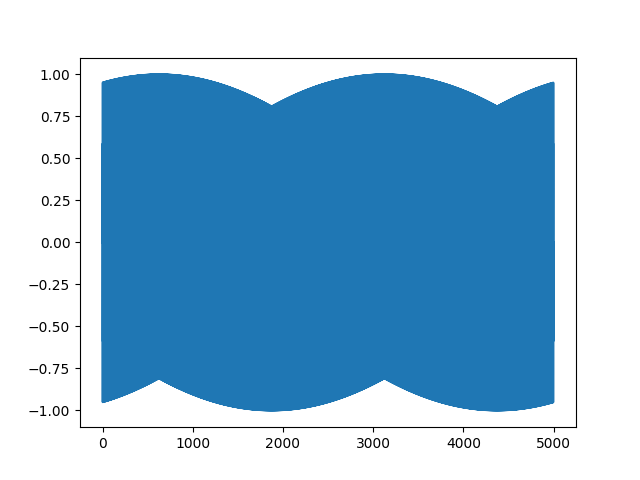

In [39]:
plt.figure()
plt.plot(np.sin(2*np.pi*peak_f*t))

100036.62109375


<IPython.core.display.Javascript object>


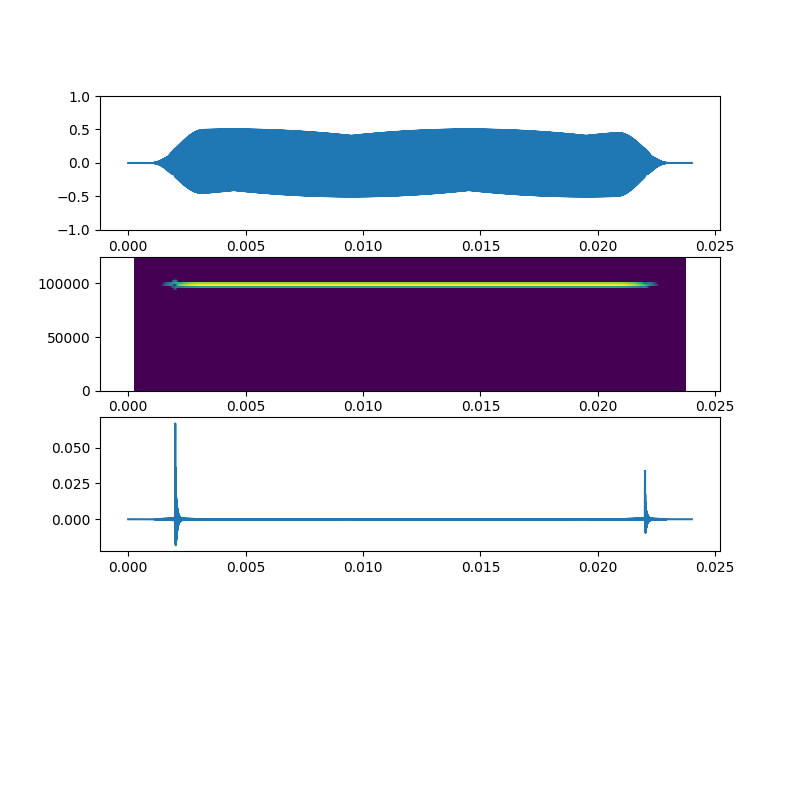

In [40]:
kwargs['q_factor'] = 1.0
#identify peak frequency 
peak_frequency = get_robust_peak_frequency(weird_cf_w_backg, **kwargs)
print(peak_frequency)
#get rid of peak frequency
nocf_weird = remove_frequency(weird_cf_w_backg, peak_frequency, **kwargs)
 
dyn_Range = dB(np.max(abs(weird_cf_w_backg)))-60
plt.figure(figsize=(8,8))
a1=plt.subplot(411)
plt.plot(np.linspace(0,weird_cf_w_backg.size/float(fs),weird_cf_w_backg.size),weird_cf_w_backg)
plt.ylim(-1,1)
plt.subplot(412,sharex=a1)
plt.specgram(weird_cf_w_backg, Fs=250000,NFFT=128,noverlap=127, vmin=dyn_Range);
plt.subplot(413,sharex=a1)
plt.plot(np.linspace(0,nocf_weird.size/float(fs),nocf_weird.size), nocf_weird)

plt.subplot(414,sharex=a1)
plt.specgram(nocf_weird, Fs=250000,NFFT=128,noverlap=127, vmin=dyn_Range);


In [41]:
weird_fm, times = get_FM_parts(nocf_weird, min_fm_duration=3*10**-3,fs=250000)

In [42]:
len(weird_fm)

2

In [43]:
times

[[228, 709], [5148, 5664]]

In [44]:
250000*0.1*10**-3

25.0

### Okay, my attempts at making a weird call by synthesising signals is not working so well because of the weird phase discontinuities etc - I know that overall the function works because of having tried it over multiple loud and faint horseshoe bat calls. This should be enough for now!

In [45]:
print('This report was last run at:', datetime.now())

('This report was last run at:', datetime.datetime(2020, 2, 13, 11, 5, 38, 759813))
